# Stroke prediction using PySpark

## Download Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tarekmuhammed/patients-data-for-medical-field")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/tarekmuhammed/patients-data-for-medical-field/versions/1


In [2]:
!ls /root/.cache/kagglehub/datasets/tarekmuhammed/patients-data-for-medical-field/versions/1

'Patients Data ( Used for Heart Disease Prediction ).xlsx'


## Import Dependencies

In [3]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import warnings
warnings.filterwarnings('ignore')


## Load Dataset

In [4]:
df = pd.read_excel(path + "/Patients Data ( Used for Heart Disease Prediction ).xlsx")

## Data preprocessing

In [5]:
df.columns

Index(['PatientID', 'State', 'Sex', 'GeneralHealth', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'HadHeartAttack',
       'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [6]:
df.head()

,PatientID,State,Sex,GeneralHealth,AgeCategory,HeightInMeters,WeightInKilograms,BMI,HadHeartAttack,HadAngina,...,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,1,Alabama,Female,Fair,Age 75 to 79,1.63,84.820000,32.099998,0,1,...,Never used e-cigarettes in my entire life,1,"White only, Non-Hispanic",0,0,0,1,"No, did not receive any tetanus shot in the pa...",0,1
1,2,Alabama,Female,Very good,Age 65 to 69,1.60,71.669998,27.990000,0,0,...,Never used e-cigarettes in my entire life,0,"White only, Non-Hispanic",0,0,1,1,"Yes, received Tdap",0,0
2,3,Alabama,Male,Excellent,Age 60 to 64,1.78,71.209999,22.530001,0,0,...,Never used e-cigarettes in my entire life,0,"White only, Non-Hispanic",1,0,0,0,"Yes, received tetanus shot but not sure what type",0,0
3,4,Alabama,Male,Very good,Age 70 to 74,1.78,95.250000,30.129999,0,0,...,Never used e-cigarettes in my entire life,0,"White only, Non-Hispanic",0,0,1,1,"Yes, received tetanus shot but not sure what type",0,0
4,5,Alabama,Female,Good,Age 50 to 54,1.68,78.019997,27.760000,0,0,...,Never used e-cigarettes in my entire life,1,"Black only, Non-Hispanic",0,0,1,0,"No, did not receive any tetanus shot in the pa...",0,0


In [7]:
df.dtypes

PatientID                      int64
State                         object
Sex                           object
GeneralHealth                 object
AgeCategory                   object
HeightInMeters               float64
WeightInKilograms            float64
BMI                          float64
HadHeartAttack                 int64
HadAngina                      int64
HadStroke                      int64
HadAsthma                      int64
HadSkinCancer                  int64
HadCOPD                        int64
HadDepressiveDisorder          int64
HadKidneyDisease               int64
HadArthritis                   int64
HadDiabetes                   object
DeafOrHardOfHearing            int64
BlindOrVisionDifficulty        int64
DifficultyConcentrating        int64
DifficultyWalking              int64
DifficultyDressingBathing      int64
DifficultyErrands              int64
SmokerStatus                  object
ECigaretteUsage               object
ChestScan                      int64
R

In [8]:
df.drop(columns=['PatientID', 'State'], inplace=True)
columns_to_encode = ['Sex', 'GeneralHealth', 'AgeCategory', 'HadDiabetes', 'SmokerStatus', 'ECigaretteUsage', 'RaceEthnicityCategory', 'TetanusLast10Tdap']

for column in columns_to_encode:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Model

## Initialize Spark Session

In [9]:
# Initialize Spark session
spark = SparkSession.builder.appName("MedicalDataAnalysis").getOrCreate()

24/11/03 03:12:08 WARN Utils: Your hostname, MSI resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/11/03 03:12:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/03 03:12:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Convert df to spark_df

In [10]:
# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(df)

## Prepare the data

In [11]:
# Prepare the data for modeling
feature_columns = [col for col in spark_df.columns if col != 'HadStroke']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
assembled_data = assembler.transform(spark_df)

## Split the data into train and test

In [12]:
# Split the data into training and test sets
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=1234)

## Train Logistic Regression Model

In [ ]:
# Train a Logistic Regression model
lr = LogisticRegression(labelCol='HadStroke', featuresCol='features')
lr_model = lr.fit(train_data)

24/11/03 03:12:38 WARN TaskSetManager: Stage 0 contains a task of very large size (1089 KiB). The maximum recommended task size is 1000 KiB.
24/11/03 03:12:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/03 03:12:43 WARN TaskSetManager: Stage 2 contains a task of very large size (1089 KiB). The maximum recommended task size is 1000 KiB.
24/11/03 03:12:44 WARN TaskSetManager: Stage 4 contains a task of very large size (1089 KiB). The maximum recommended task size is 1000 KiB.
24/11/03 03:12:45 WARN TaskSetManager: Stage 6 contains a task of very large size (1089 KiB). The maximum recommended task size is 1000 KiB.
24/11/03 03:12:45 WARN TaskSetManager: Stage 8 contains a task of very large size (1089 KiB). The maximum recommended task size is 1000 KiB.
24/11/03 03:12:45 WARN TaskSetManager: Stage 10 contains a task of very large size (1089 KiB). The maximum recommended task size is 1000 KiB.
24/11/03 03:12:45 WARN TaskSetManager: Stage 1

## Make Predictions

In [14]:
# Make predictions on the test set
predictions = lr_model.transform(test_data)

## Evaluate the Model

In [ ]:
# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol='HadStroke')
accuracy = evaluator.evaluate(predictions)

print(f"Model Accuracy: {accuracy}")

24/11/03 02:53:30 WARN TaskSetManager: Stage 0 contains a task of very large size (1089 KiB). The maximum recommended task size is 1000 KiB.
24/11/03 02:53:37 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/03 02:53:37 WARN TaskSetManager: Stage 2 contains a task of very large size (1089 KiB). The maximum recommended task size is 1000 KiB.
24/11/03 02:53:39 WARN TaskSetManager: Stage 4 contains a task of very large size (1089 KiB). The maximum recommended task size is 1000 KiB.
24/11/03 02:53:39 WARN TaskSetManager: Stage 6 contains a task of very large size (1089 KiB). The maximum recommended task size is 1000 KiB.
24/11/03 02:53:39 WARN TaskSetManager: Stage 8 contains a task of very large size (1089 KiB). The maximum recommended task size is 1000 KiB.
24/11/03 02:53:39 WARN TaskSetManager: Stage 10 contains a task of very large size (1089 KiB). The maximum recommended task size is 1000 KiB.
24/11/03 02:53:40 WARN TaskSetManager: Stage 1

Model Accuracy: 0.8153749566562986


## Plot HeatMap

24/11/03 03:12:49 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/11/03 03:12:49 WARN TaskSetManager: Stage 72 contains a task of very large size (1089 KiB). The maximum recommended task size is 1000 KiB.


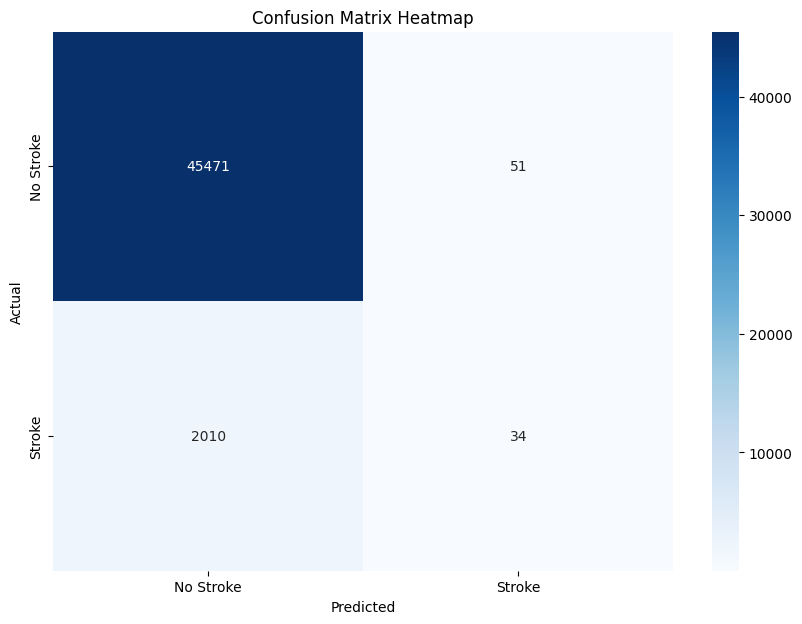

In [15]:
# Convert Spark DataFrame to Pandas DataFrame
predictions_pd = predictions.select('prediction', 'HadStroke').toPandas()

# Create confusion matrix
conf_matrix = confusion_matrix(predictions_pd['HadStroke'], predictions_pd['prediction'])

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Stop Spark Session

In [16]:
spark.stop()

## Conclusion

This notebook demonstrates the process of predicting stroke occurrences using a dataset of patient data. By leveraging PySpark, we efficiently handled and processed a large dataset, performed feature engineering, and trained a logistic regression model. The model's performance was evaluated, and the results were visualized using a confusion matrix heatmap. This workflow highlights the power of combining PySpark for big data processing with traditional machine learning techniques to derive meaningful insights from healthcare data.